# INV 2025 — Limpieza, EDA, Texto y Borrador de KG
**Versión:** 2025-10-01  
Este cuaderno está ordenado para que puedas ejecutarlo de arriba hacia abajo y ver **todo en el output** (sin escribir a disco).  
Cada sección explica su propósito y qué esperar en la salida.


## 0) Utilidades de visualización
Pequeñas funciones auxiliares para mostrar tablas y gráficas sin dependencias extra (solo `matplotlib`).

In [2]:

from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def show_table(df: pd.DataFrame, title: str = "", max_rows: int = 10):
    if title:
        print(f"\n— {title} —")
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        display_dataframe_to_user(title or "Tabla", df.head(max_rows))
    except Exception:
        display(df.head(max_rows))

def plot_histograms(df: pd.DataFrame, cols: List[str], bins: int = 30):
    for c in cols:
        if pd.api.types.is_numeric_dtype(df[c]):
            plt.figure()
            df[c].dropna().hist(bins=bins)
            plt.title(f"Histograma: {c}")
            plt.xlabel(c)
            plt.ylabel("Frecuencia")
            plt.show()

def plot_boxplots(df: pd.DataFrame, cols: List[str]):
    for c in cols:
        if pd.api.types.is_numeric_dtype(df[c]) and df[c].dropna().size > 0:
            plt.figure()
            plt.boxplot(df[c].dropna().values, vert=True, labels=[c])
            plt.title(f"Boxplot: {c}")
            plt.ylabel(c)
            plt.show()

def heatmap_matrix(mat: np.ndarray, xlabels: List[str], ylabels: List[str], title: str):
    plt.figure()
    plt.imshow(mat, aspect='auto')  # no specify colors
    plt.colorbar()
    plt.xticks(ticks=range(len(xlabels)), labels=xlabels, rotation=90)
    plt.yticks(ticks=range(len(ylabels)), labels=ylabels)
    plt.title(title)
    plt.tight_layout()
    plt.show()


## 1) Configuración y carga de datos
**Propósito:** Cargar el dataset o usar un `DataFrame df` ya presente en el entorno.  
- Si `df` ya existe, se usa tal cual.  
- Si no existe, define `CSV_PATH` y se cargará desde disco.


In [3]:

from pathlib import Path
import pandas as pd
import numpy as np

CSV_PATH = Path("INV_2025.csv")  # cambia si tu archivo tiene otro nombre o ruta

if "df" in globals():
    print("✔︎ Usando DataFrame `df` existente:", df.shape)
else:
    if CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        print("✔︎ Cargado desde CSV:", CSV_PATH, "| shape:", df.shape)
    else:
        raise FileNotFoundError("No existe `df` ni el archivo especificado en CSV_PATH. Ajusta CSV_PATH o crea `df`.")


✔︎ Cargado desde CSV: INV_2025.csv | shape: (153501, 11)


## 2) Panorama general y calidad de datos
**Propósito:** Entender la forma, tipos, valores faltantes y ver muestras para detectar problemas obvios.

In [4]:

print("Shape:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

na_summary = df.isna().mean().sort_values(ascending=False).to_frame("pct_na")
show_table(na_summary, "Porcentaje de faltantes por columna")

show_table(df.sample(min(len(df), 5), random_state=0), "Muestra aleatoria (5 filas)")


Shape: (153501, 11)

Tipos de datos:
ACTION_NUMBER     object
MAKE              object
MODEL             object
YEAR             float64
COMPONENT         object
MFG_NAME          object
ODATE            float64
CDATE            float64
CAMP_NO           object
SUBJECT           object
SUMMARY           object
dtype: object

— Porcentaje de faltantes por columna —


,pct_na
CDATE,0.492668
CAMP_NO,0.183048
MAKE,0.008847
MODEL,0.008847
YEAR,0.008847
COMPONENT,0.008847
MFG_NAME,0.008847
SUMMARY,0.003622
ODATE,0.001023
ACTION_NUMBER,0.000000



— Muestra aleatoria (5 filas) —


,ACTION_NUMBER,MAKE,MODEL,YEAR,COMPONENT,MFG_NAME,ODATE,CDATE,CAMP_NO,SUBJECT,SUMMARY
41768,DP18003,HYUNDAI,SONATA,2013.0,ELECTRICAL SYSTEM:STARTER ASSEMBLY,Hyundai Motor America,20180821.0,20190510.0,18V934000,Non-crash Vehicle Fires,"In a letter dated June 11, 2018, the Center fo..."
109418,EA15001,HONDA,PILOT,2007.0,AIR BAGS,Honda (American Honda Motor Co.),20150224.0,NaN,16V358,Air Bag Inflator Rupture,The Office of Defects Investigation (ODI) open...
126550,EA15001,DODGE,DURANGO,2004.0,AIR BAGS,"Chrysler (FCA US, LLC)",20150224.0,NaN,18V018,Air Bag Inflator Rupture,The Office of Defects Investigation (ODI) open...
95514,EA86025,CADILLAC,FLEETWOOD,1985.0,VISIBILITY,"General Motors, LLC",19860825.0,19880302.0,NaN,WINDSHIELD WIPERS,SUMMARY:GM BELIEVES THE PROBLEM HAS BEEN CORRE...
125042,EA15001,BMW,M3,2005.0,AIR BAGS,"BMW of North America, LLC",20150224.0,NaN,19V781,Air Bag Inflator Rupture,The Office of Defects Investigation (ODI) open...


## 3) Estandarización de texto (solo stopwords **EN** para fingerprints)
**Propósito:** Normalizar campos clave (`MAKE`, `MODEL`, `COMPONENT`, `MFG_NAME`, `SUBJECT`, `SUMMARY`) para análisis consistente.  
- Se hace `strip/lower`, remoción de acentos y símbolos.  
- Se crean fingerprints de `SUBJECT`/`SUMMARY` para detectar **near-duplicates** usando **stopwords en inglés solamente**.


In [5]:

import re
import unicodedata

def strip_accents(s: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalize_token(s: str) -> str:
    s = str(s).strip().lower()
    s = strip_accents(s)
    s = re.sub(r"[^a-z0-9 ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

text_key_cols = [c for c in ["MAKE","MODEL","COMPONENT","MFG_NAME"] if c in df.columns]
for c in text_key_cols:
    df[c] = df[c].astype("string").map(lambda x: normalize_token(x) if pd.notna(x) else x)

STOP_EN = {"the","of","and","to","in","a","for","is","on","that","with","as","by","at","from","it","be","this","an","are","or","not","have","has","was","were"}

def fingerprint_english(s):
    if pd.isna(s): return ""
    s = normalize_token(s)
    toks = [t for t in s.split() if t not in STOP_EN]
    return " ".join(sorted(toks))

for col in [c for c in ["SUBJECT","SUMMARY"] if c in df.columns]:
    df[f"{col}_fp"] = df[col].astype("string").map(fingerprint_english)

# Resumen near-duplicates
for col in [c for c in ["SUBJECT","SUMMARY"] if c in df.columns]:
    dup_flag = df[f"{col}_fp"].duplicated(keep=False)
    print(f"{col}: near-duplicates (fingerprint exacto) ->", int(dup_flag.sum()))
    show_table(df.loc[dup_flag, [col, f"{col}_fp"]].head(10), f"Ejemplos de near-duplicates en {col}")


SUBJECT: near-duplicates (fingerprint exacto) -> 152075

— Ejemplos de near-duplicates en SUBJECT —


,SUBJECT,SUBJECT_fp
0,HID REPLACEMENT KIT RECALL CAMPAIGNS,campaigns hid kit recall replacement
1,SPARK PLUG EJECTION FROM CYLINDER HEAD,cylinder ejection head plug spark
2,SPARK PLUG EJECTION FROM CYLINDER HEAD,cylinder ejection head plug spark
3,HID REPLACEMENT KIT RECALL CAMPAIGNS,campaigns hid kit recall replacement
4,HID REPLACEMENT KIT RECALL CAMPAIGNS,campaigns hid kit recall replacement
5,SEAT BACK FAILURE,back failure seat
6,Recall Administration Concerns,administration concerns recall
7,SPARK PLUG EJECTION FROM CYLINDER HEAD,cylinder ejection head plug spark
8,SPARK PLUG EJECTION FROM CYLINDER HEAD,cylinder ejection head plug spark
9,STEERING COLUMN SEPARATION,column separation steering


SUMMARY: near-duplicates (fingerprint exacto) -> 152827

— Ejemplos de near-duplicates en SUMMARY —


,SUMMARY,SUMMARY_fp
0,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
1,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
2,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
3,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
4,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
5,ODI HAS IDENTIFIED 30 INCIDENTS WHERE IT IS AL...,2004 207 23 29 30 60 69 absorptioncapabilities...
6,"On September 14, 2017, Diono LLC (Diono) submi...",000 000 003 003 003 003 003 003 052 120 14 17c...
7,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
8,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
9,MR. LARRY A. SACKEY SUBMITTED A PETITION TO TH...,130 18 1987 1993 1993 1994 1995 1995 1995 2003...


## 4) Fechas y reglas de negocio
**Propósito:** Parsear `ODATE`/`CDATE`, validar integridad (`ODATE ≤ CDATE`), derivar `state` y `duration_days`.  
- Si el caso está abierto (`CDATE` nula), `duration_days` se calcula respecto **hoy** (proxy).


In [6]:

if "ODATE" in df.columns:
    df["ODATE"] = pd.to_datetime(df["ODATE"], errors="coerce")
if "CDATE" in df.columns:
    df["CDATE"] = pd.to_datetime(df["CDATE"], errors="coerce")

if {"ODATE","CDATE"}.issubset(df.columns):
    df["state"] = np.where(df["CDATE"].notna(), "closed", "open")
    today = pd.Timestamp("today").normalize()
    df["duration_days"] = np.where(
        df["CDATE"].notna(),
        (df["CDATE"] - df["ODATE"]).dt.days,
        (today - df["ODATE"]).dt.days
    )
    bad = (df["CDATE"].notna()) & (df["CDATE"] < df["ODATE"])
    print("Violaciones CDATE<ODATE:", int(bad.sum()))
    show_table(df[["ODATE","CDATE","state","duration_days"]].head(10), "Derivados de fechas (muestra)")
else:
    print("⚠︎ No se pudo derivar estado/duración: faltan ODATE/CDATE.")


Violaciones CDATE<ODATE: 19

— Derivados de fechas (muestra) —


,ODATE,CDATE,state,duration_days
0,1970-01-01 00:00:00.020090326,1970-01-01 00:00:00.020090706,closed,0.0
1,1970-01-01 00:00:00.020050922,1970-01-01 00:00:00.020060104,closed,0.0
2,1970-01-01 00:00:00.020050922,1970-01-01 00:00:00.020060104,closed,0.0
3,1970-01-01 00:00:00.020090326,1970-01-01 00:00:00.020090706,closed,0.0
4,1970-01-01 00:00:00.020090326,1970-01-01 00:00:00.020090706,closed,0.0
5,1970-01-01 00:00:00.020030923,1970-01-01 00:00:00.020040408,closed,0.0
6,1970-01-01 00:00:00.020180719,1970-01-01 00:00:00.020211206,closed,0.0
7,1970-01-01 00:00:00.020050922,1970-01-01 00:00:00.020060104,closed,0.0
8,1970-01-01 00:00:00.020050922,1970-01-01 00:00:00.020060104,closed,0.0
9,1970-01-01 00:00:00.020030507,1970-01-01 00:00:00.020030722,closed,0.0


## 5) Optimización de tipos y memoria
**Propósito:** Reducir uso de memoria y mejorar performance.  
- *Downcast* numéricos.  
- Convertir objetos de baja diversidad a `category`.


In [7]:

before_mb = df.memory_usage(deep=True).sum()/1e6

for c in df.select_dtypes(include=[np.number]).columns:
    try:
        df[c] = pd.to_numeric(df[c], downcast="integer")
        df[c] = pd.to_numeric(df[c], downcast="float")
    except Exception as e:
        print(f"Downcast falló en {c}: {e}")

for c in df.select_dtypes(include=["object"]).columns:
    try:
        ratio = df[c].nunique(dropna=True) / max(len(df), 1)
        if ratio < 0.5:
            df[c] = df[c].astype("category")
    except Exception as e:
        print(f"Categorical cast falló en {c}: {e}")

after_mb = df.memory_usage(deep=True).sum()/1e6
print(f"Memoria: antes={before_mb:.2f} MB | después={after_mb:.2f} MB | ahorro={before_mb-after_mb:.2f} MB")


Memoria: antes=792.95 MB | después=15.18 MB | ahorro=777.77 MB


## 6) Manejo de categorías raras (inline)
**Propósito:** Evitar sparsidad en análisis categóricos colapsando categorías con frecuencia < 1% en **Other**.  
Se muestra el conteo antes/después para 3 columnas categóricas con más cardinalidad.


In [8]:

RARE_TH = 0.01
cat_cols = [c for c in df.columns if str(df[c].dtype) in ("category","object")]
# Ordenar por cardinalidad (desc) y tomar top 3 para mostrar
top_cats = sorted(cat_cols, key=lambda c: df[c].nunique(dropna=True), reverse=True)[:3]

for c in top_cats:
    print(f"\nColumna: {c}")
    vc_before = df[c].value_counts(dropna=False).head(10)
    show_table(vc_before.to_frame("count"), f"{c}: Top categorías (antes)")
    # Construir y aplicar mapa
    freq = df[c].value_counts(normalize=True, dropna=False)
    rares = set(freq[freq < RARE_TH].index)
    def _collapse(v):
        if pd.isna(v): return v
        return "Other" if v in rares else v
    df[c] = df[c].map(_collapse)
    vc_after = df[c].value_counts(dropna=False).head(10)
    show_table(vc_after.to_frame("count"), f"{c}: Top categorías (después)")



Columna: ACTION_NUMBER

— ACTION_NUMBER: Top categorías (antes) —


,count
ACTION_NUMBER,
EA15001,71004
PE19004,7840
DP18003,7072
PE19003,6048
PE14016,3294
EA21002,2776
EA05005,2037
EQ08011,1890
AQ09001,1120



— ACTION_NUMBER: Top categorías (después) —


,count
ACTION_NUMBER,
EA15001,71004
Other,51540
PE19004,7840
DP18003,7072
PE19003,6048
PE14016,3294
EA21002,2776
EA05005,2037
EQ08011,1890



Columna: SUBJECT

— SUBJECT: Top categorías (antes) —


,count
SUBJECT,
Air Bag Inflator Rupture,74305
Non-crash Vehicle Fires,20960
ENGINE COMPARTMENT FIRES,2783
Desiccated Air Bag Inflator Rupture,2776
RICON/THRESHOLD WARNING/ANTI-STOW,1890
Extended Stopping Distance,1150
HID REPLACEMENT KIT RECALL CAMPAIGNS,1120
Pedestrian alert sounds,938
Sudden Unintended Acceleration,817



— SUBJECT: Top categorías (después) —


,count
SUBJECT,
Air Bag Inflator Rupture,74305
Other,50787
Non-crash Vehicle Fires,20960
ENGINE COMPARTMENT FIRES,2783
Desiccated Air Bag Inflator Rupture,2776
RICON/THRESHOLD WARNING/ANTI-STOW,1890



Columna: MODEL

— MODEL: Top categorías (antes) —


,count
MODEL,
element,3678
soul,3616
accord,3019
sonata,2787
sonata hybrid,2640
santa fe,2624
sorento,2483
optima,2464
mazda6,2456



— MODEL: Top categorías (después) —


,count
MODEL,
Other,98853
element,3678
soul,3616
accord,3019
sonata,2787
sonata hybrid,2640
santa fe,2624
sorento,2483
optima,2464


## 7) Duplicados y *near-duplicates* (texto)
**Propósito:** Detectar filas con descripciones potencialmente duplicadas para limpieza o consolidación posterior.


In [9]:

dup_cols = [c for c in ["SUBJECT_fp","SUMMARY_fp"] if c in df.columns]
if dup_cols:
    dup_any = np.zeros(len(df), dtype=bool)
    for dc in dup_cols:
        dup_any |= df[dc].duplicated(keep=False).values
    print("Filas marcadas como near-duplicate por alguna fingerprint:", int(dup_any.sum()))
    show_table(df.loc[dup_any, [c.replace("_fp","") for c in dup_cols] + dup_cols].head(10), "Ejemplos near-duplicate")
else:
    print("No hay columnas de fingerprint para evaluar near-duplicates.")


Filas marcadas como near-duplicate por alguna fingerprint: 153039

— Ejemplos near-duplicate —


,SUBJECT,SUMMARY,SUBJECT_fp,SUMMARY_fp
0,Other,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,campaigns hid kit recall replacement,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
1,Other,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",cylinder ejection head plug spark,1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
2,Other,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",cylinder ejection head plug spark,1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
3,Other,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,campaigns hid kit recall replacement,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
4,Other,RMD IDENTIFIED SEVERAL HID REPLACEMENT LIGHTIN...,campaigns hid kit recall replacement,066 066 066 06e 06e 06e 06e 07e 07e 080 084 08...
5,Other,ODI HAS IDENTIFIED 30 INCIDENTS WHERE IT IS AL...,back failure seat,2004 207 23 29 30 60 69 absorptioncapabilities...
6,Other,"On September 14, 2017, Diono LLC (Diono) submi...",administration concerns recall,000 000 003 003 003 003 003 003 052 120 14 17c...
7,Other,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",cylinder ejection head plug spark,1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
8,Other,"ON SEPTEMBER 6, 2005, ODI RECEIVED A PETITION ...",cylinder ejection head plug spark,1 10 10 1997 1997 2 2002 2004 2005 2005 3 319 ...
9,Other,MR. LARRY A. SACKEY SUBMITTED A PETITION TO TH...,column separation steering,130 18 1987 1993 1993 1994 1995 1995 1995 2003...


## 8) EDA numérico
**Propósito:** Explorar distribución y relación de variables numéricas.  
- `describe()` ordenado por conteo.  
- Histogramas y boxplots de las 6 columnas numéricas con más datos.  
- Matriz de correlación (Spearman) y *heatmap*.



— Resumen numérico (describe) —


,count,mean,std,min,25%,50%,75%,max
duration_days,153344.0,10020.273438,10178.780273,-1.0,0.0,0.0,20360.0,20360.0
YEAR,152143.0,2370.682861,1669.744263,1965.0,2003.0,2005.0,2011.0,9999.0


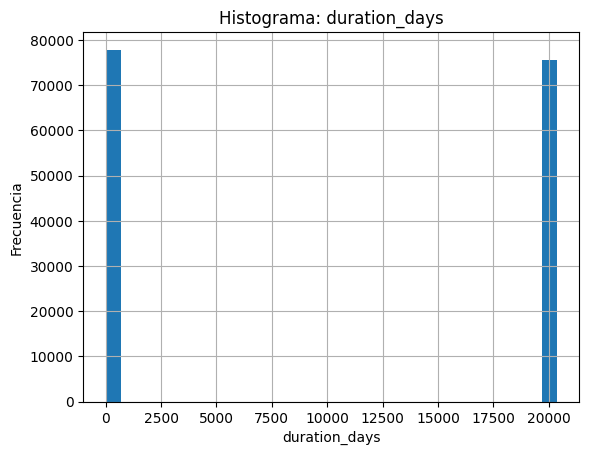

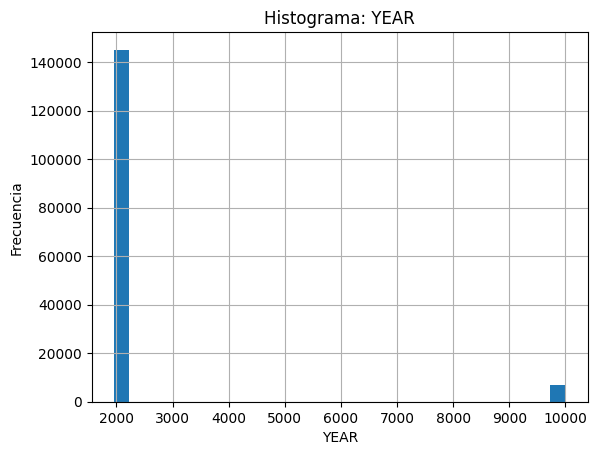

/var/folders/_7/1zf2xp_55rq61_zjzydkzfk40000gn/T/ipykernel_32028/3043708680.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna().values, vert=True, labels=[c])


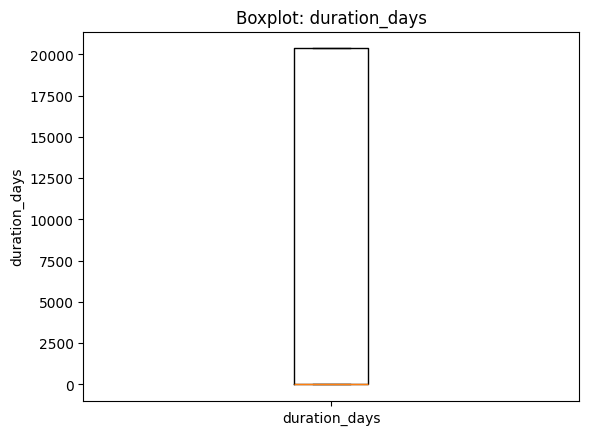

/var/folders/_7/1zf2xp_55rq61_zjzydkzfk40000gn/T/ipykernel_32028/3043708680.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[c].dropna().values, vert=True, labels=[c])


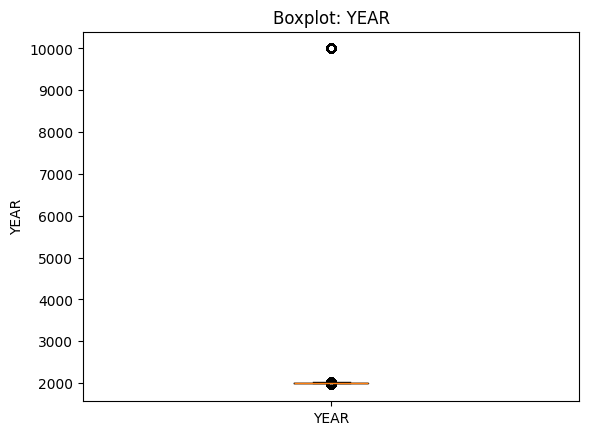


— Matriz de correlación (Spearman) —


,YEAR,duration_days
YEAR,1.000000,-0.171476
duration_days,-0.171476,1.000000


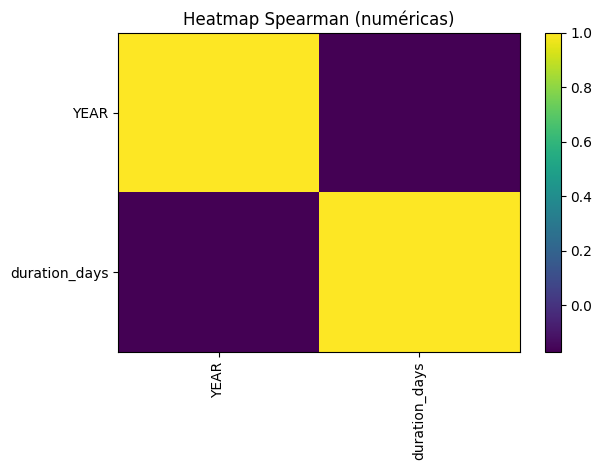

In [10]:

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if num_cols:
    desc = df[num_cols].describe().T.sort_values("count", ascending=False)
    show_table(desc, "Resumen numérico (describe)")
    top_num = [c for c in desc.index.tolist()[:6] if df[c].dropna().size > 0]
    plot_histograms(df, top_num, bins=30)
    plot_boxplots(df, top_num)
    # Correlación Spearman
    cor = df[num_cols].corr(method="spearman")
    show_table(cor, "Matriz de correlación (Spearman)")
    heatmap_matrix(cor.values, cor.columns.tolist(), cor.index.tolist(), "Heatmap Spearman (numéricas)")
else:
    print("No se detectaron columnas numéricas.")


## 9) EDA categórico
**Propósito:** Revisar la distribución de categorías, especialmente tras el colapso de raras.


In [11]:

cat_cols = [c for c in df.columns if str(df[c].dtype) in ("category","object")]
for c in cat_cols[:5]:  # muestra hasta 5 columnas
    vc = df[c].value_counts(dropna=False).head(10)
    show_table(vc.to_frame("count"), f"{c}: Top categorías")



— ACTION_NUMBER: Top categorías —


,count
ACTION_NUMBER,
EA15001,71004
Other,51540
PE19004,7840
DP18003,7072
PE19003,6048
PE14016,3294
EA21002,2776
EA05005,2037
EQ08011,1890



— MAKE: Top categorías —


,count
MAKE,
honda,16552
dodge,13356
kia,12796
ford,10338
bmw,9879
hyundai,9832
mazda,7300
toyota,6326
chrysler,4888



— MODEL: Top categorías —


,count
MODEL,
Other,98853
element,3678
soul,3616
accord,3019
sonata,2787
sonata hybrid,2640
santa fe,2624
sorento,2483
optima,2464



— COMPONENT: Top categorías —


,count
COMPONENT,
air bags,37845
air bags frontal,37679
service brakes hydraulic,2526
electrical system,2459
vehicle speed control linkages,2329
engine and engine cooling,2083
equipment mechanical wrecker and wheel lift devices,1902
air bags frontal driver side inflator module,1558
suspension,1520



— MFG_NAME: Top categorías —


,count
MFG_NAME,
chrysler fca us llc,20746
honda american honda motor co,20067
kia america inc,12810
ford motor company,11732
general motors llc,10806
bmw of north america llc,10062
hyundai motor america,9852
toyota motor corporation,8423
nissan north america inc,7681


## 10) Matriz de asociaciones mixta
**Propósito:** Medir fuerza de asociación entre pares de variables mixtas:  
- Numérico–Numérico: **Spearman**  
- Categórico–Categórico: **Cramér V (corregido)**  
- Categórico–Numérico: **Razón de correlación (η)**  
Se muestran los pares con mayor |score|.


In [12]:

def spearman_robust(s1, s2):
    s = pd.concat([s1, s2], axis=1).dropna()
    if s.shape[0] < 3: return np.nan
    x = s.iloc[:,0].rank()
    y = s.iloc[:,1].rank()
    return x.corr(y)

def cramers_v_corrected_from_table(confusion):
    if hasattr(confusion, "values"):
        confusion = confusion.values
    confusion = np.asarray(confusion, dtype=float)
    n = confusion.sum()
    if n == 0: return np.nan
    row_sums = confusion.sum(axis=1).reshape(-1, 1)
    col_sums = confusion.sum(axis=0).reshape(1, -1)
    expected = (row_sums @ col_sums) / n
    mask = expected > 0
    chi2 = ((confusion[mask] - expected[mask])**2 / expected[mask]).sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0.0, phi2 - ((k-1)*(r-1))/(n-1)) if n > 1 else 0.0
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    denom = max(min(kcorr-1, rcorr-1), 1e-12)
    return float(np.sqrt(phi2corr / denom))

def correlation_ratio(categories, measurements):
    s = pd.DataFrame({"cat": categories, "num": measurements}).dropna()
    if s.empty: return np.nan
    codes = pd.Categorical(s["cat"]).codes
    y = s["num"].values.astype(float)
    y_mean = y.mean()
    ss_between = 0.0
    for k in np.unique(codes):
        y_k = y[codes == k]
        if y_k.size == 0: continue
        ss_between += y_k.size * (y_k.mean() - y_mean)**2
    ss_total = ((y - y_mean)**2).sum()
    return float(np.sqrt(ss_between / ss_total)) if ss_total > 0 else np.nan

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in df.columns if str(df[c].dtype) in ("category","object")]

pairs = []
selected = list(cat_cols) + list(num_cols)
for i, c1 in enumerate(selected):
    for c2 in selected[i+1:]:
        s1, s2 = df[c1], df[c2]
        try:
            if c1 in num_cols and c2 in num_cols:
                score, metric = spearman_robust(s1, s2), "spearman"
            elif c1 in cat_cols and c2 in cat_cols:
                tbl = pd.crosstab(s1, s2, dropna=True)
                score, metric = (cramers_v_corrected_from_table(tbl), "cramers_v") if tbl.size else (np.nan, "cramers_v")
            else:
                cat, num = (s1, s2) if c1 in cat_cols else (s2, s1)
                score, metric = correlation_ratio(cat, num), "eta"
        except Exception:
            score, metric = np.nan, "error"
        pairs.append((c1, c2, score, metric))

assoc = pd.DataFrame(pairs, columns=["col_i","col_j","score","metric"]).dropna(subset=["score"])
assoc["abs_score"] = assoc["score"].abs()
assoc_top = assoc.sort_values(["abs_score"], ascending=False).head(30)
show_table(assoc_top.drop(columns=["abs_score"]), "Top asociaciones por |score| (30)")



— Top asociaciones por |score| (30) —


,col_i,col_j,score,metric
76,state,duration_days,1.000000,eta
64,SUMMARY,SUMMARY_fp,0.999940,cramers_v
56,CAMP_NO,duration_days,0.999740,eta
74,SUMMARY_fp,duration_days,0.999545,eta
67,SUMMARY,duration_days,0.999544,eta
8,ACTION_NUMBER,SUMMARY_fp,0.991369,cramers_v
6,ACTION_NUMBER,SUMMARY,0.991279,cramers_v
72,SUMMARY_fp,state,0.988893,cramers_v
4,ACTION_NUMBER,CAMP_NO,0.988849,cramers_v
65,SUMMARY,state,0.988793,cramers_v


## 11) Borrador de nodos/aristas para KG (sin escribir a disco)
**Propósito:** Generar DataFrames de nodos y relaciones clave para un primer vistazo del grafo.  
- Nodos: `VEHICLE (MAKE, MODEL, YEAR)`, `MFG (MFG_NAME)`, `COMPONENT (COMPONENT)`, `CASE (ROW_ID, state, duration_days)`  
- Aristas: `(CASE)-[INVOLVES]->(VEHICLE)`, `(VEHICLE)-[MANUFACTURED_BY]->(MFG)`, `(VEHICLE)-[HAS_COMPONENT]->(COMPONENT)`  
Se muestran **shapes** y **muestras** de cada tabla resultante.


In [13]:

import hashlib

def hid(prefix, *vals):
    s = "||".join([str(v) for v in vals])
    return f"{prefix}:{hashlib.sha1(s.encode()).hexdigest()[:10]}"

available = set(df.columns)
needed_vehicle = {"MAKE","MODEL","YEAR"}
needed_mfg = {"MFG_NAME"}
needed_comp = {"COMPONENT"}

nodes_vehicle = nodes_mfg = nodes_comp = nodes_case = edges = None

if needed_vehicle.issubset(available):
    veh = df[list(needed_vehicle)].dropna().drop_duplicates()
    veh = veh.assign(
        MAKE=lambda x: x["MAKE"].astype(str),
        MODEL=lambda x: x["MODEL"].astype(str)
    )
    veh = veh.assign(node_id=veh.apply(lambda r: hid("veh", r.MAKE, r.MODEL, r.YEAR), axis=1))
    nodes_vehicle = veh.assign(label="VEHICLE")[["node_id","label","MAKE","MODEL","YEAR"]]
    print("nodes_vehicle:", nodes_vehicle.shape)
    show_table(nodes_vehicle, "nodes_vehicle (muestra)")
else:
    print("⚠︎ Faltan columnas para VEHICLE:", needed_vehicle - available)

if needed_mfg.issubset(available):
    mfg = df[["MFG_NAME"]].dropna().drop_duplicates()
    mfg = mfg.assign(MFG_NAME=lambda x: x["MFG_NAME"].astype(str))
    mfg["node_id"] = mfg["MFG_NAME"].map(lambda v: hid("mfg", v))
    nodes_mfg = mfg.assign(label="MFG")[["node_id","label","MFG_NAME"]]
    print("nodes_mfg:", nodes_mfg.shape)
    show_table(nodes_mfg, "nodes_mfg (muestra)")
else:
    print("⚠︎ Falta MFG_NAME para nodos MFG.")

if needed_comp.issubset(available):
    comp = df[["COMPONENT"]].dropna().drop_duplicates()
    comp = comp.assign(COMPONENT=lambda x: x["COMPONENT"].astype(str))
    comp["node_id"] = comp["COMPONENT"].map(lambda v: hid("cmp", v))
    nodes_comp = comp.assign(label="COMPONENT")[["node_id","label","COMPONENT"]]
    print("nodes_component:", nodes_comp.shape)
    show_table(nodes_comp, "nodes_component (muestra)")
else:
    print("⚠︎ Falta COMPONENT para nodos COMPONENT.")

if {"ODATE","CDATE"}.issubset(available):
    if "state" not in df.columns or "duration_days" not in df.columns:
        state_tmp = np.where(df["CDATE"].notna(), "closed", "open")
        today = pd.Timestamp("today").normalize()
        duration_tmp = np.where(df["CDATE"].notna(),
                                (df["CDATE"] - df["ODATE"]).dt.days,
                                (today - df["ODATE"]).dt.days)
        case_df = pd.DataFrame({"state": state_tmp, "duration_days": duration_tmp})
    else:
        case_df = df[["state","duration_days"]].copy()

    case_df = case_df.reset_index().rename(columns={"index":"ROW_ID"})
    case_df["node_id"] = case_df["ROW_ID"].map(lambda v: hid("case", v))
    nodes_case = case_df[["node_id","ROW_ID","state","duration_days"]].assign(label="CASE")
    print("nodes_case:", nodes_case.shape)
    show_table(nodes_case, "nodes_case (muestra)")

    edges_list = []
    for i, row in df.reset_index().iterrows():
        case_id = hid("case", row["index"])
        veh_id = None
        if needed_vehicle.issubset(available):
            mk, md, yr = row.get("MAKE"), row.get("MODEL"), row.get("YEAR")
            if pd.notna(mk) and pd.notna(md) and pd.notna(yr):
                veh_id = hid("veh", str(mk), str(md), yr)
        if veh_id:
            edges_list.append((case_id, "INVOLVES", veh_id))
            if "MFG_NAME" in available and pd.notna(row.get("MFG_NAME")):
                edges_list.append((veh_id, "MANUFACTURED_BY", hid("mfg", str(row.get("MFG_NAME")))))
            if "COMPONENT" in available and pd.notna(row.get("COMPONENT")):
                edges_list.append((veh_id, "HAS_COMPONENT", hid("cmp", str(row.get("COMPONENT")))))
    if edges_list:
        edges = pd.DataFrame(edges_list, columns=["src","rel","dst"])
        print("edges:", edges.shape)
        show_table(edges, "edges (muestra)")
    else:
        print("No se generaron aristas (puede faltar MAKE/MODEL/YEAR en varias filas).")
else:
    print("⚠︎ Faltan ODATE/CDATE para nodos CASE y aristas.")


nodes_vehicle: (4600, 5)

— nodes_vehicle (muestra) —


,node_id,label,MAKE,MODEL,YEAR
0,veh:38fb853065,VEHICLE,capcen,Other,9999.0
1,veh:072cc2dffa,VEHICLE,ford,Other,2001.0
2,veh:15f03b3331,VEHICLE,ford,Other,2000.0
3,veh:38a195af7e,VEHICLE,eastone,Other,9999.0
5,veh:d2c10308da,VEHICLE,dodge,ram 1500,1997.0
6,veh:16a10cc063,VEHICLE,diono,Other,9999.0
7,veh:fa42a534ab,VEHICLE,lincoln,Other,2004.0
8,veh:74a7900b3f,VEHICLE,ford,Other,1999.0
9,veh:bbc4a351d6,VEHICLE,chrysler,Other,1994.0
10,veh:01d833b9a9,VEHICLE,delta,Other,9999.0


nodes_mfg: (586, 3)

— nodes_mfg (muestra) —


,node_id,label,MFG_NAME
0,mfg:729853331b,MFG,auto paw trading inc
1,mfg:0adee596c5,MFG,ford motor company
3,mfg:9b254a6bdd,MFG,vehicle enhancement specialty products
5,mfg:76f6059354,MFG,chrysler fca us llc
6,mfg:a65702c0e1,MFG,diono
10,mfg:6396f3fa52,MFG,delta tech industries llc
11,mfg:7ce0fa8d42,MFG,accubuilt inc
13,mfg:27ef64c450,MFG,wu s international trade
15,mfg:539eeb52d3,MFG,toyota motor corporation
19,mfg:47daf029fa,MFG,monaco coach corporation


nodes_component: (415, 3)

— nodes_component (muestra) —


,node_id,label,COMPONENT
0,cmp:5056bf2df9,COMPONENT,exterior lighting
1,cmp:bc2f6bc6ab,COMPONENT,engine and engine cooling
3,cmp:c240d91458,COMPONENT,exterior lighting headlights
5,cmp:4be16ee588,COMPONENT,seats front assembly recliner
6,cmp:7381f0d6e1,COMPONENT,child seat
7,cmp:b08ad9f5b2,COMPONENT,engine and engine cooling engine
8,cmp:d0bf76bdb8,COMPONENT,engine and engine cooling engine gasoline
9,cmp:441924ee94,COMPONENT,steering column
15,cmp:f673211c01,COMPONENT,vehicle speed control
19,cmp:88b15bc540,COMPONENT,electrical system wiring fuses and circuit bre...


nodes_case: (153501, 5)

— nodes_case (muestra) —


,node_id,ROW_ID,state,duration_days,label
0,case:b6589fc6ab,0,closed,0.0,CASE
1,case:356a192b79,1,closed,0.0,CASE
2,case:da4b9237ba,2,closed,0.0,CASE
3,case:77de68daec,3,closed,0.0,CASE
4,case:1b64538924,4,closed,0.0,CASE
5,case:ac3478d69a,5,closed,0.0,CASE
6,case:c1dfd96eea,6,closed,0.0,CASE
7,case:902ba3cda1,7,closed,0.0,CASE
8,case:fe5dbbcea5,8,closed,0.0,CASE
9,case:0ade7c2cf9,9,closed,0.0,CASE


edges: (456429, 3)

— edges (muestra) —


,src,rel,dst
0,case:b6589fc6ab,INVOLVES,veh:38fb853065
1,veh:38fb853065,MANUFACTURED_BY,mfg:729853331b
2,veh:38fb853065,HAS_COMPONENT,cmp:5056bf2df9
3,case:356a192b79,INVOLVES,veh:072cc2dffa
4,veh:072cc2dffa,MANUFACTURED_BY,mfg:0adee596c5
5,veh:072cc2dffa,HAS_COMPONENT,cmp:bc2f6bc6ab
6,case:da4b9237ba,INVOLVES,veh:15f03b3331
7,veh:15f03b3331,MANUFACTURED_BY,mfg:0adee596c5
8,veh:15f03b3331,HAS_COMPONENT,cmp:bc2f6bc6ab
9,case:77de68daec,INVOLVES,veh:38a195af7e


## 12) Próximos pasos sugeridos
- Revisión de reglas de negocio por dominio (por ejemplo, validación adicional de `YEAR`, mapping de `COMPONENT` a una taxonomía estándar).  
- Enriquecimiento de texto: extracción de entidades (NER), n-gramas caracter, y clustering temático para `(CASE)-[MENTIONS]->(TERM)`.  
- Export a formato de grafo (CSV, Parquet) o carga directa a Neo4j/NetworkX para consultas.


## 13) Extracción de entidades (NER) desde SUBJECT / SUMMARY
**Propósito:** Detectar entidades nombradas y términos clave a partir de los textos para enriquecer el grafo con nodos `(TERM)` y aristas `(CASE)-[MENTIONS]->(TERM)`.

**Notas:**
- Si `spaCy` y el modelo `en_core_web_sm` están disponibles, se usan; si no, se aplica un **fallback heurístico** (tokenización simple + stopwords EN + filtros de longitud).
- No escribimos a disco; todo se muestra en la salida.


In [14]:

# Intento de NER con spaCy; fallback a heurística si no está disponible
import re
import pandas as pd
import numpy as np

try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
        print("✔︎ spaCy en_core_web_sm cargado.")
    except Exception as e:
        print("⚠︎ spaCy instalado pero no se pudo cargar 'en_core_web_sm':", e)
        nlp = None
except Exception as e:
    print("⚠︎ spaCy no está disponible:", e)
    nlp = None

STOP_EN = {"the","of","and","to","in","a","for","is","on","that","with","as","by","at","from","it","be","this","an","are","or","not","have","has","was","were"}

def fallback_terms(text: str):
    # Heurística simple: tokens alfanuméricos, sin stopwords, longitud>=3
    if not isinstance(text, str) or not text.strip():
        return []
    toks = re.findall(r"[A-Za-z0-9]{3,}", text.lower())
    toks = [t for t in toks if t not in STOP_EN and not t.isdigit()]
    # devolver como (term, type) donde type='TERM' genérico
    return [(t, "TERM") for t in toks]

def extract_terms_series(series: pd.Series):
    terms_per_row = []
    if nlp is not None:
        texts = series.fillna("").astype(str).tolist()
        for doc in nlp.pipe(texts, disable=["tagger","parser","lemmatizer"], batch_size=64):
            row_terms = []
            for ent in doc.ents:
                # Tipos comunes de interés
                if ent.label_ in {"ORG","GPE","PRODUCT","DATE","TIME","CARDINAL","NORP","LOC","LAW","FAC","EVENT"}:
                    row_terms.append((ent.text.strip(), ent.label_))
            if not row_terms:
                # Reforzamos con fallback si NER no encontró nada
                row_terms = fallback_terms(doc.text)
            terms_per_row.append(row_terms)
    else:
        # Solo fallback
        terms_per_row = [fallback_terms(x) for x in series.fillna("").astype(str).tolist()]
    return terms_per_row

text_cols = [c for c in ["SUBJECT","SUMMARY"] if c in df.columns]
if text_cols:
    combined_text = df[text_cols].astype(str).agg(" ".join, axis=1)
    terms_by_row = extract_terms_series(combined_text)

    # Construir tabla de términos con conteos globales
    all_terms = [ (t.lower().strip(), typ) for row in terms_by_row for (t,typ) in row if isinstance(t, str) and t.strip() ]
    terms_df = pd.DataFrame(all_terms, columns=["term","type"])
    if not terms_df.empty:
        terms_df["term_norm"] = terms_df["term"].str.lower().str.strip()
        terms_df = terms_df.groupby(["term_norm","type"], as_index=False).agg(freq=("term","count"))
        terms_df = terms_df.sort_values("freq", ascending=False)
        show_table(terms_df.head(20), "Top términos/entidades extraídas")
    else:
        print("No se extrajeron términos/entidades.")
else:
    terms_df = pd.DataFrame(columns=["term_norm","type","freq"])
    terms_by_row = []
    print("No existen columnas SUBJECT/SUMMARY.")


⚠︎ spaCy no está disponible: No module named 'spacy'

— Top términos/entidades extraídas —


,term_norm,type,freq
13341,vehicles,TERM,965210
6420,inflators,TERM,873557
8412,odi,TERM,814971
12126,takata,TERM,685593
7521,manufacturers,TERM,606080
958,all,TERM,566342
6419,inflator,TERM,531980
13331,vehicle,TERM,530158
8682,other,TERM,424406
6702,investigation,TERM,412433


## 14) Taxonomía de COMPONENT: mapeo canónico y jerárquico (SYSTEM → SUBSYSTEM → COMPONENT)
**Propósito:** Unificar valores heterogéneos de `COMPONENT` y, si está ausente o ambiguo, inferir por palabras clave en `SUBJECT/SUMMARY`.
- Devuelve tres columnas: `comp_system`, `comp_subsystem`, `comp_canonical` y el `comp_source` de donde vino el mapeo (columna o texto).
- Reglas iniciales **heurísticas** (ajústalas a tu dominio para mayor precisión).


In [15]:

import re

# Reutiliza normalize_token si fue definida; si no, define una mínima
try:
    normalize_token
except NameError:
    def normalize_token(s: str) -> str:
        s = str(s).strip().lower()
        s = re.sub(r"[^a-z0-9 ]+", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

TAXONOMY_RULES = [
    {"keywords": ["air bag","airbag","srs"], "system":"SAFETY", "subsystem":"AIRBAG", "canonical":"airbag"},
    {"keywords": ["seat belt","seatbelt","pretensioner"], "system":"SAFETY", "subsystem":"SEAT_BELT", "canonical":"seat_belt"},
    {"keywords": ["brake","abs","booster","caliper"], "system":"BRAKE", "subsystem":"BRAKE_SYSTEM", "canonical":"brake_system"},
    {"keywords": ["steer","eps","rack","column"], "system":"STEERING", "subsystem":"STEERING_SYSTEM", "canonical":"steering"},
    {"keywords": ["engine","powertrain","oil","coolant"], "system":"POWERTRAIN", "subsystem":"ENGINE", "canonical":"engine"},
    {"keywords": ["transmission","gearbox","clutch","tcm"], "system":"POWERTRAIN", "subsystem":"TRANSMISSION", "canonical":"transmission"},
    {"keywords": ["suspension","shock","strut","spring","control arm"], "system":"CHASSIS", "subsystem":"SUSPENSION", "canonical":"suspension"},
    {"keywords": ["fuel","tank","pump","injector"], "system":"FUEL", "subsystem":"FUEL_SYSTEM", "canonical":"fuel_system"},
    {"keywords": ["electrical","wiring","harness","battery","alternator","ecu","pcm","bcm","can"], "system":"ELECTRICAL", "subsystem":"ELECTRICAL_SYSTEM", "canonical":"electrical"},
    {"keywords": ["lighting","headlamp","taillight","indicator"], "system":"BODY", "subsystem":"LIGHTING", "canonical":"lighting"},
    {"keywords": ["hvac","ac","air conditioning","heater","blower"], "system":"HVAC", "subsystem":"HVAC", "canonical":"hvac"},
    {"keywords": ["tire","wheel","rim"], "system":"CHASSIS", "subsystem":"TIRES_WHEELS", "canonical":"tires_wheels"},
    {"keywords": ["body","door","hood","tailgate","bumper"], "system":"BODY", "subsystem":"BODY", "canonical":"body"}
]

def match_taxonomy(text_norm: str):
    t = text_norm or ""
    for rule in TAXONOMY_RULES:
        for kw in rule["keywords"]:
            if kw in t:
                return rule["system"], rule["subsystem"], rule["canonical"]
    return ("OTHER","OTHER", t[:50] if t else "unknown")

def infer_component_from_text(row):
    txt = ""
    for c in ["SUBJECT","SUMMARY"]:
        if c in row and pd.notna(row[c]):
            txt += " " + str(row[c])
    return match_taxonomy(normalize_token(txt))

# Aplicar: primero intenta con columna COMPONENT, luego inferir de texto si no asignó nada útil
comp_system = []
comp_subsystem = []
comp_canonical = []
comp_source = []

for _, r in df.iterrows():
    sys, sub, can = ("OTHER","OTHER","unknown")
    src = "unmapped"
    if "COMPONENT" in df.columns and pd.notna(r.get("COMPONENT")):
        sys, sub, can = match_taxonomy(normalize_token(r.get("COMPONENT")))
        src = "COMPONENT_col"
    if can in ("", "unknown") or sys=="OTHER":
        s2, ssub2, can2 = infer_component_from_text(r)
        if (s2, ssub2) != ("OTHER","OTHER"):
            sys, sub, can, src = s2, ssub2, can2, "text_subject_summary"
    comp_system.append(sys)
    comp_subsystem.append(sub)
    comp_canonical.append(can)
    comp_source.append(src)

df["comp_system"] = comp_system
df["comp_subsystem"] = comp_subsystem
df["comp_canonical"] = comp_canonical
df["comp_source"] = comp_source

# Resumen de cómo quedó el mapeo
summary_tax = (df
    .groupby(["comp_system","comp_subsystem","comp_canonical","comp_source"], dropna=False)
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
show_table(summary_tax.head(20), "Resumen taxonomía (top 20 combinaciones)")



— Resumen taxonomía (top 20 combinaciones) —


,comp_system,comp_subsystem,comp_canonical,comp_source,count
40,SAFETY,AIRBAG,airbag,COMPONENT_col,79595
10,ELECTRICAL,ELECTRICAL_SYSTEM,electrical,COMPONENT_col,12767
36,POWERTRAIN,ENGINE,engine,COMPONENT_col,11061
2,BODY,LIGHTING,lighting,COMPONENT_col,9201
4,BRAKE,BRAKE_SYSTEM,brake_system,COMPONENT_col,8508
12,FUEL,FUEL_SYSTEM,fuel_system,COMPONENT_col,3847
6,CHASSIS,SUSPENSION,suspension,COMPONENT_col,3309
8,CHASSIS,TIRES_WHEELS,tires_wheels,COMPONENT_col,3196
44,STEERING,STEERING_SYSTEM,steering,COMPONENT_col,2937
15,HVAC,HVAC,hvac,text_subject_summary,2500


## 15) KG enriquecido con TEXTO: nodos `(TERM)` y aristas `(CASE)-[MENTIONS]->(TERM)` + taxonomía de COMPONENT
**Propósito:** Integrar la información textual al grafo para consultas semánticas.
- Crea nodos `TERM(term_norm, type, freq)`.
- Crea aristas `(CASE)-[MENTIONS]->(TERM)` a partir de `SUBJECT/SUMMARY`.
- Los nodos `VEHICLE/MFG/COMPONENT` incorporan la `comp_canonical` cuando sea posible.


In [16]:

import hashlib

def hid(prefix, *vals):
    s = "||".join([str(v) for v in vals])
    return f"{prefix}:{hashlib.sha1(s.encode()).hexdigest()[:10]}"

available = set(df.columns)

# 1) Nodos TERM desde terms_df
if 'terms_df' in globals() and not terms_df.empty:
    nodes_term = terms_df.assign(node_id=lambda x: x.apply(lambda r: hid("term", r["term_norm"], r["type"]), axis=1)) \
                         [["node_id","term_norm","type","freq"]]
    nodes_term = nodes_term.rename(columns={"term_norm":"term"}).assign(label="TERM")
    print("nodes_term:", nodes_term.shape)
    show_table(nodes_term, "nodes_term (muestra)")
else:
    nodes_term = None
    print("No hay terms_df para construir nodos TERM.")

# 2) Aristas MENTIONS desde terms_by_row
edges_mentions = None
if 'terms_by_row' in globals() and terms_by_row:
    em_list = []
    for i, row_terms in enumerate(terms_by_row):
        case_id = hid("case", i)
        # Evitar explosión: usar set por fila
        uniq = {(str(t).lower().strip(), typ) for (t,typ) in row_terms if isinstance(t, str) and t.strip()}
        for term, typ in uniq:
            term_id = hid("term", term, typ)
            em_list.append((case_id, "MENTIONS", term_id))
    if em_list:
        edges_mentions = pd.DataFrame(em_list, columns=["src","rel","dst"])
        print("edges_mentions:", edges_mentions.shape)
        show_table(edges_mentions.head(20), "edges_mentions (muestra)")
    else:
        print("No se generaron aristas MENTIONS (terms_by_row vacío).")
else:
    print("terms_by_row no definido; no se generan MENTIONS.")

# 3) Nodos VEHICLE/MFG/COMPONENT (con comp_canonical)
nodes_vehicle = nodes_mfg = nodes_comp = nodes_case = None

if {"MAKE","MODEL","YEAR"}.issubset(available):
    veh = df[["MAKE","MODEL","YEAR"]].dropna().drop_duplicates()
    veh = veh.assign(MAKE=lambda x: x["MAKE"].astype(str), MODEL=lambda x: x["MODEL"].astype(str))
    veh = veh.assign(node_id=veh.apply(lambda r: hid("veh", r.MAKE, r.MODEL, r.YEAR), axis=1))
    nodes_vehicle = veh.assign(label="VEHICLE")[["node_id","label","MAKE","MODEL","YEAR"]]
    print("nodes_vehicle:", nodes_vehicle.shape)
    show_table(nodes_vehicle, "nodes_vehicle (muestra)")

if {"MFG_NAME"}.issubset(available):
    mfg = df[["MFG_NAME"]].dropna().drop_duplicates().assign(MFG_NAME=lambda x: x["MFG_NAME"].astype(str))
    mfg["node_id"] = mfg["MFG_NAME"].map(lambda v: hid("mfg", v))
    nodes_mfg = mfg.assign(label="MFG")[["node_id","label","MFG_NAME"]]
    print("nodes_mfg:", nodes_mfg.shape)
    show_table(nodes_mfg, "nodes_mfg (muestra)")

# COMPONENT prioriza comp_canonical si existe
comp_source_col = "comp_canonical" if "comp_canonical" in df.columns else "COMPONENT"
if comp_source_col in df.columns:
    comp = df[[comp_source_col]].dropna().drop_duplicates()
    comp = comp.rename(columns={comp_source_col:"COMPONENT_CANON"})
    comp = comp.assign(COMPONENT_CANON=lambda x: x["COMPONENT_CANON"].astype(str))
    comp["node_id"] = comp["COMPONENT_CANON"].map(lambda v: hid("cmp", v))
    nodes_comp = comp.assign(label="COMPONENT")[["node_id","label","COMPONENT_CANON"]]
    print("nodes_component:", nodes_comp.shape)
    show_table(nodes_comp, "nodes_component (muestra)")

# 4) Nodos CASE y aristas INVOLVES / MANUFACTURED_BY / HAS_COMPONENT
if {"ODATE","CDATE"}.issubset(available):
    if "state" not in df.columns or "duration_days" not in df.columns:
        state_tmp = np.where(df["CDATE"].notna(), "closed", "open")
        today = pd.Timestamp("today").normalize()
        duration_tmp = np.where(df["CDATE"].notna(),
                                (df["CDATE"] - df["ODATE"]).dt.days,
                                (today - df["ODATE"]).dt.days)
        case_df = pd.DataFrame({"state": state_tmp, "duration_days": duration_tmp})
    else:
        case_df = df[["state","duration_days"]].copy()
    case_df = case_df.reset_index().rename(columns={"index":"ROW_ID"})
    case_df["node_id"] = case_df["ROW_ID"].map(lambda v: hid("case", v))
    nodes_case = case_df[["node_id","ROW_ID","state","duration_days"]].assign(label="CASE")
    print("nodes_case:", nodes_case.shape)
    show_table(nodes_case, "nodes_case (muestra)")

    edges_rel = []
    for i, row in df.reset_index().iterrows():
        case_id = hid("case", row["index"])
        veh_id = None
        if {"MAKE","MODEL","YEAR"}.issubset(available):
            mk, md, yr = row.get("MAKE"), row.get("MODEL"), row.get("YEAR")
            if pd.notna(mk) and pd.notna(md) and pd.notna(yr):
                veh_id = hid("veh", str(mk), str(md), yr)
        if veh_id:
            edges_rel.append((case_id, "INVOLVES", veh_id))
            if "MFG_NAME" in available and pd.notna(row.get("MFG_NAME")):
                edges_rel.append((veh_id, "MANUFACTURED_BY", hid("mfg", str(row.get("MFG_NAME")))))
            # COMPONENT canonical si existe
            comp_val = row.get("comp_canonical") if "comp_canonical" in df.columns else row.get("COMPONENT")
            if pd.notna(comp_val):
                edges_rel.append((veh_id, "HAS_COMPONENT", hid("cmp", str(comp_val))))
    if edges_rel:
        edges_rel_df = pd.DataFrame(edges_rel, columns=["src","rel","dst"])
        print("edges_rel:", edges_rel_df.shape)
        show_table(edges_rel_df.head(20), "edges_rel (muestra)")
else:
    print("⚠︎ Faltan ODATE/CDATE para nodos CASE y relaciones base.")

# 5) Comentario de valor/limitaciones
print("\\nNota: El valor de integrar texto depende de la calidad del NER y del dominio. Con `spaCy` genérico puede haber ruido (términos técnicos mal tipados).")
print("Recomendación: curar diccionarios para COMPONENT y un 'gazetteer' de términos del dominio (DTCs, sensores, módulos, códigos de falla) para mejorar precisión.")


nodes_term: (13966, 5)

— nodes_term (muestra) —


,node_id,term,type,freq,label
13341,term:b7a4b7d0ba,vehicles,TERM,965210,TERM
6420,term:4fd9184852,inflators,TERM,873557,TERM
8412,term:2c0b901261,odi,TERM,814971,TERM
12126,term:a17477a128,takata,TERM,685593,TERM
7521,term:231de96849,manufacturers,TERM,606080,TERM
958,term:8d34329e40,all,TERM,566342,TERM
6419,term:640448fec4,inflator,TERM,531980,TERM
13331,term:2b3e154b97,vehicle,TERM,530158,TERM
8682,term:ccaee8c34b,other,TERM,424406,TERM
6702,term:39b70f91eb,investigation,TERM,412433,TERM


edges_mentions: (21673542, 3)

— edges_mentions (muestra) —


,src,rel,dst
0,case:b6589fc6ab,MENTIONS,term:c7ff60a001
1,case:b6589fc6ab,MENTIONS,term:f168929a40
2,case:b6589fc6ab,MENTIONS,term:d483762fc3
3,case:b6589fc6ab,MENTIONS,term:6e88d5720f
4,case:b6589fc6ab,MENTIONS,term:a798649f92
5,case:b6589fc6ab,MENTIONS,term:281a6565a6
6,case:b6589fc6ab,MENTIONS,term:5f6700c3ba
7,case:b6589fc6ab,MENTIONS,term:31664dd453
8,case:b6589fc6ab,MENTIONS,term:4c7da6d887
9,case:b6589fc6ab,MENTIONS,term:ddfe69defa


nodes_vehicle: (4600, 5)

— nodes_vehicle (muestra) —


,node_id,label,MAKE,MODEL,YEAR
0,veh:38fb853065,VEHICLE,capcen,Other,9999.0
1,veh:072cc2dffa,VEHICLE,ford,Other,2001.0
2,veh:15f03b3331,VEHICLE,ford,Other,2000.0
3,veh:38a195af7e,VEHICLE,eastone,Other,9999.0
5,veh:d2c10308da,VEHICLE,dodge,ram 1500,1997.0
6,veh:16a10cc063,VEHICLE,diono,Other,9999.0
7,veh:fa42a534ab,VEHICLE,lincoln,Other,2004.0
8,veh:74a7900b3f,VEHICLE,ford,Other,1999.0
9,veh:bbc4a351d6,VEHICLE,chrysler,Other,1994.0
10,veh:01d833b9a9,VEHICLE,delta,Other,9999.0


nodes_mfg: (586, 3)

— nodes_mfg (muestra) —


,node_id,label,MFG_NAME
0,mfg:729853331b,MFG,auto paw trading inc
1,mfg:0adee596c5,MFG,ford motor company
3,mfg:9b254a6bdd,MFG,vehicle enhancement specialty products
5,mfg:76f6059354,MFG,chrysler fca us llc
6,mfg:a65702c0e1,MFG,diono
10,mfg:6396f3fa52,MFG,delta tech industries llc
11,mfg:7ce0fa8d42,MFG,accubuilt inc
13,mfg:27ef64c450,MFG,wu s international trade
15,mfg:539eeb52d3,MFG,toyota motor corporation
19,mfg:47daf029fa,MFG,monaco coach corporation


nodes_component: (33, 3)

— nodes_component (muestra) —


,node_id,label,COMPONENT_CANON
0,cmp:3eeb51742b,COMPONENT,lighting
1,cmp:c64033672f,COMPONENT,engine
5,cmp:ace9b2538b,COMPONENT,brake_system
6,cmp:73a097c0d0,COMPONENT,electrical
9,cmp:9654c78027,COMPONENT,steering
21,cmp:d3497cfd32,COMPONENT,hvac
24,cmp:0cd60f6c0b,COMPONENT,tires_wheels
40,cmp:90204a96f2,COMPONENT,fuel_system
51,cmp:066b4eb7b4,COMPONENT,suspension
63,cmp:0daf320cf2,COMPONENT,vehicle speed control linkages


nodes_case: (153501, 5)

— nodes_case (muestra) —


,node_id,ROW_ID,state,duration_days,label
0,case:b6589fc6ab,0,closed,0.0,CASE
1,case:356a192b79,1,closed,0.0,CASE
2,case:da4b9237ba,2,closed,0.0,CASE
3,case:77de68daec,3,closed,0.0,CASE
4,case:1b64538924,4,closed,0.0,CASE
5,case:ac3478d69a,5,closed,0.0,CASE
6,case:c1dfd96eea,6,closed,0.0,CASE
7,case:902ba3cda1,7,closed,0.0,CASE
8,case:fe5dbbcea5,8,closed,0.0,CASE
9,case:0ade7c2cf9,9,closed,0.0,CASE


edges_rel: (456429, 3)

— edges_rel (muestra) —


,src,rel,dst
0,case:b6589fc6ab,INVOLVES,veh:38fb853065
1,veh:38fb853065,MANUFACTURED_BY,mfg:729853331b
2,veh:38fb853065,HAS_COMPONENT,cmp:3eeb51742b
3,case:356a192b79,INVOLVES,veh:072cc2dffa
4,veh:072cc2dffa,MANUFACTURED_BY,mfg:0adee596c5
5,veh:072cc2dffa,HAS_COMPONENT,cmp:c64033672f
6,case:da4b9237ba,INVOLVES,veh:15f03b3331
7,veh:15f03b3331,MANUFACTURED_BY,mfg:0adee596c5
8,veh:15f03b3331,HAS_COMPONENT,cmp:c64033672f
9,case:77de68daec,INVOLVES,veh:38a195af7e


\nNota: El valor de integrar texto depende de la calidad del NER y del dominio. Con `spaCy` genérico puede haber ruido (términos técnicos mal tipados).
Recomendación: curar diccionarios para COMPONENT y un 'gazetteer' de términos del dominio (DTCs, sensores, módulos, códigos de falla) para mejorar precisión.
